In [1]:
pip install patchify

#Import Librairies

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import matplotlib.pyplot as plt
import matplotlib
import os
import numpy as np
import cv2
import pandas as pd
from PIL import Image
from patchify import patchify


In [3]:
root_directory=r'/content/drive/MyDrive/Deep Learning/Semantic segmentation dataset'

#Data Preprocessing

The images vary in size, but they need to be standardized to a consistent size for further processing.

In segmentation tasks, simple resizing isn't ideal. Instead, we will transform our images into fixed-size patches by cropping them, ensuring each image can be divided uniformly into these patches.

In [4]:
patch_size=256
image_dataset=[]
mask_dataset=[]

Patching the Images

In [5]:
for path, subdirs, files in os.walk(root_directory):
  dirname = path.split(os.path.sep)[-1]
  if dirname == 'images':
      images = sorted(os.listdir(path)) #os.listdir reads the folder in random order which results in masks and images not corresponding
      #Crop images so their dimensions adapt to our patch size
      for i,image_name in enumerate(images):
        image=cv2.imread(path +"/"+ image_name,1)
        x_size=(image.shape[1]//patch_size)*patch_size
        y_size=(image.shape[0]//patch_size)*patch_size
        image= Image.fromarray(image)
        image=image.crop((0,0,x_size,y_size))
        image=np.array(image)
        patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap

        for i in range(patches_img.shape[0]):
            for j in range(patches_img.shape[1]):
                  single_patch_img = patches_img[i,j,:,:]
                  single_patch_img = (single_patch_img.astype('float32')) / 255. #normalizing/scaling the image
                  single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.
                  image_dataset.append(single_patch_img)



Patching the corresponding masks

In [6]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()


In [7]:
for path, subdirs, files in os.walk(root_directory):
  dirname = path.split(os.path.sep)[-1]
  if dirname == 'masks':
      masks = sorted(os.listdir(path))
      #Crop images so their dimensions adapt to our patch size
      for i,mask_name in enumerate(masks):
        mask=cv2.imread(path +"/"+ mask_name,1)
        mask=cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
        x_size=(mask.shape[1]//patch_size)*patch_size
        y_size=(mask.shape[0]//patch_size)*patch_size
        mask= Image.fromarray(mask)
        mask=mask.crop((0,0,x_size,y_size))
        mask=np.array(mask)
        patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap

        for i in range(patches_mask.shape[0]):
            for j in range(patches_mask.shape[1]):
                  single_patch_mask = patches_mask[i,j,:,:]
                  single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                  single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.
                  mask_dataset.append(single_patch_mask)

In [8]:
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)

Visualizing the dataset to make sure that the images and masks correspond

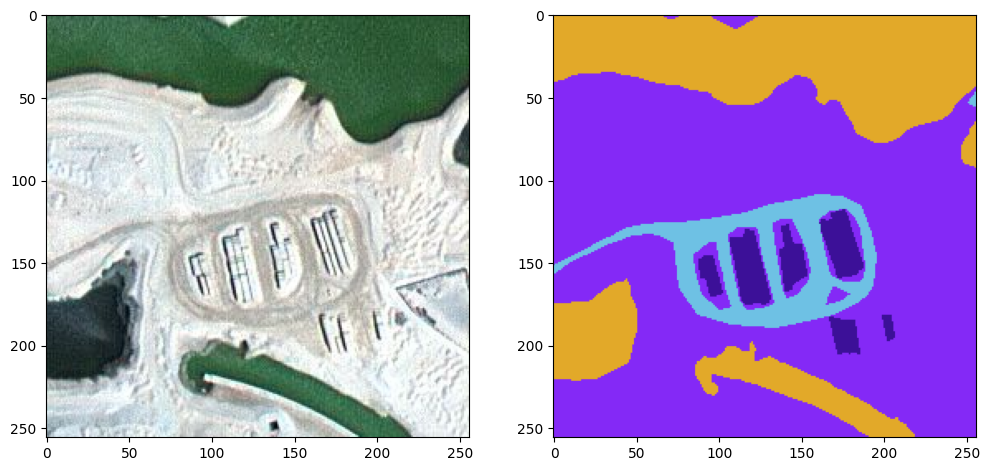

In [9]:
import random
num=random.randint(0,len(image_dataset)-1)
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(np.reshape(image_dataset[num], (patch_size, patch_size, 3)))
plt.subplot(1,2,2)
plt.imshow(np.reshape(mask_dataset[num],(patch_size, patch_size, 3)))

The dataset comprises aerial imagery of Dubai captured by MBRSC satellites, annotated for pixel-wise semantic segmentation across six classes:

Building: #3C1098
Land (unpaved area): #8429F6
Road: #6EC1E4
Vegetation: #FEDD3A
Water: #E2A929
Unlabeled: #9B9B9B

Since the labels are encoded in hexadecimal format, we will convert them to RGB values, then to integers, and finally apply one-hot encoding for model training.

In [10]:
print(int('8C',16))

140


this is obtained by the formula : 8*16+12=140
We will therefore convert our values that way

Initializing the classes with their **hexcodes**

In [11]:
Building='3C1098'
Land='8429F6'
Road='6EC1E4'
Vegetation= 'FEDD3A'
Water='E2A929'
Unlabeled='9B9B9B'

In [12]:
Building= np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4)))
Land= np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4)))
Road= np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4)))
Vegetation= np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4)))
Water= np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4)))
Unlabeled= np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4)))

In [13]:
print(Building[0])

60


In [14]:
print(Building)

[ 60  16 152]


These represent in RGB RED=60, GREEN=16 Blue=152

In [15]:
label=single_patch_mask
label.shape

(256, 256, 3)

maintenant le but est d'affecter un integer à chaque couleur/classe

In [16]:
def rgb_to_2D_label(label):
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == Building,axis=-1)] = 0
    label_seg [np.all(label==Land,axis=-1)] = 1
    label_seg [np.all(label==Road,axis=-1)] = 2
    label_seg [np.all(label==Vegetation,axis=-1)] = 3
    label_seg [np.all(label==Water,axis=-1)] = 4
    label_seg [np.all(label==Unlabeled,axis=-1)] = 5

    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels

    return label_seg

labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)

labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)

In [17]:
n_classes =len(np.unique(labels))
n_classes

6

#Building the U-Net model

In [18]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K
def multi_unet_model(n_classes=6, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)  # Original 0.1
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [19]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
# Assuming labels is a 2D array of shape (height, width)
n_classes = len(np.unique(labels))

# Convert labels to one-hot encoding
#labels_cat = to_categorical(labels, num_classes=n_classes)

# Ensure image_dataset is in the correct shape (e.g., (num_samples, height, width, channels))
# It should match the number of samples in labels_cat after one-hot encoding
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels, test_size=0.20, random_state=42)

# Check the shapes of the split data
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (1044, 256, 256, 3)
y_train shape: (1044, 256, 256, 1)
X_test shape: (261, 256, 256, 3)
y_test shape: (261, 256, 256, 1)


In [20]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
n_classes=6
metrics=['accuracy']
print(IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)

256 256 3


#Training the model

In [21]:
model = multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)
#model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=metrics)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 16)   │            448 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256, 256, 16)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 16)   │          2,320 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 16)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 32)   │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128, 128, 32)   │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 32)   │          9,248 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 32)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 64, 64, 64)     │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 64)     │         36,928 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 64)     │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 32, 32, 128)    │              0 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 128)    │        147,584 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 128)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)    

 Total params: 1,941,190 (7.41 MB)

 Trainable params: 1,941,190 (7.41 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
history1 = model.fit(X_train, y_train,
                    batch_size = 16,
                    verbose=1,
                    epochs=50,
                    validation_data=(X_test, y_test),
                    shuffle=False)

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - accuracy: 0.8066 - loss: 0.5810 - val_accuracy: 0.7219 - val_loss: 0.7884
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 0.8061 - loss: 0.5798 - val_accuracy: 0.7520 - val_loss: 0.7218
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 0.8135 - loss: 0.5564 - val_accuracy: 0.7684 - val_loss: 0.6871
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 0.8205 - loss: 0.5353 - val_accuracy: 0.7826 - val_loss: 0.6479
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 0.8225 - loss: 0.5295 - val_accuracy: 0.7830 - val_loss: 0.6639
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - accuracy: 0.8237 - loss: 0.5260 - val_accuracy: 0.7925 - val_loss: 0.6384
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - accuracy: 0.8260 - loss: 0.5174 - val_accuracy: 0.8009 - val_loss: 0.6084
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 0.8299 - loss: 0.5062 - val_accurac